# Final Conclusions

#### Import

In [106]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal, norm, uniform, zscore
from ipywidgets import interact, interactive

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import pymc as pm

import hashlib

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

import statsmodels.api as sm

import bambi as bmb

import arviz as az

from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(max_features=1)

from sklearn.model_selection import train_test_split

In [107]:
candidates = pd.read_csv("candidate_finance.csv")

## Research Question 1:
How does money raised and spent on the 2018 primary campaigns affect whether candidates will advance or not? Are these good features to use in predicting primary advancement?

In [108]:
cand_noout = candidates[np.abs(zscore(candidates["Net_Contribution"])) < 3]
cand_noout = candidates[np.abs(zscore(candidates["Net_Operating_Expenditure"])) < 3]

In [109]:
#log quantitative variables of interest

logged_cont = np.log(cand_noout["Net_Contribution"].replace(0))
logged_expend = np.log(cand_noout["Net_Operating_Expenditure"].replace(0))
pd.options.mode.chained_assignment = None # Big warning about setting a copy of a df slice otherwise
cand_noout["Logged Net Contribution"] = logged_cont
cand_noout["Logged Operating Expenditures"] = logged_expend
pd.options.mode.chained_assignment = None # Big warning about setting a copy of a df slice otherwise
logged_loans = np.log(cand_noout["Total_Loan"].replace(0, np.nan)) # Replacing 0s with NaNs to avoid -inf values
cand_noout["Logged Total Loan"] = logged_loans

# Add column for number of candidates in each race
cand_noout["# Cands in Race"] = cand_noout.groupby("District")["Candidate"].transform("count")

# One hot encoding relevant variables
one_hot = pd.get_dummies(cand_noout['Political Party'])
cand_noout = cand_noout.join(one_hot)
one_hot = pd.get_dummies(cand_noout['Primary Status'])
cand_noout = cand_noout.join(one_hot)
one_hot = pd.get_dummies(cand_noout['State'])
cand_noout = cand_noout.join(one_hot)

#### Research Question 1 Quantitative EDA

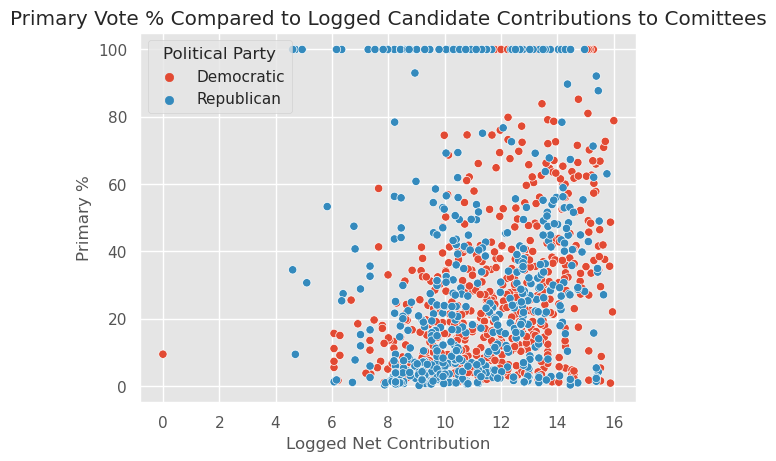

In [110]:
sns.scatterplot(data = cand_noout, x = "Logged Net Contribution", y = "Primary %", hue = "Political Party").set_title("Primary Vote % Compared to Logged Candidate Contributions to Comittees");

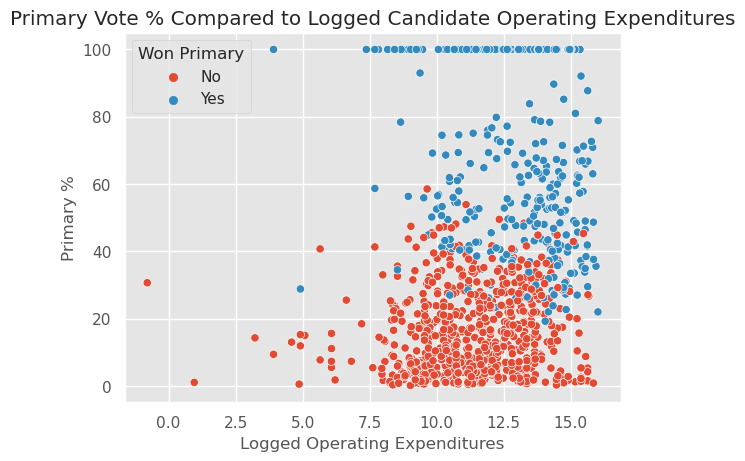

In [111]:
sns.scatterplot(data = cand_noout, x = "Logged Operating Expenditures", y = "Primary %", hue = "Won Primary").set_title("Primary Vote % Compared to Logged Candidate Operating Expenditures");

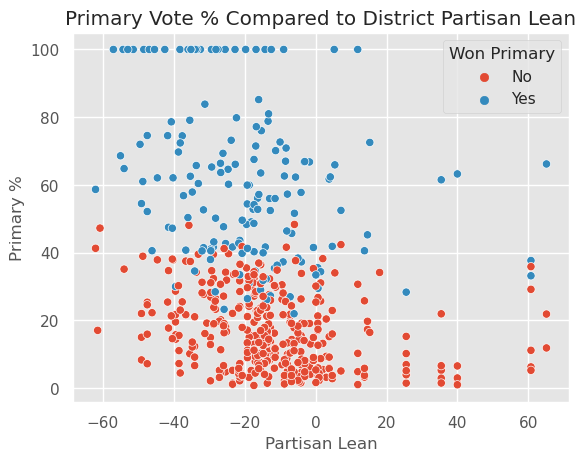

In [112]:
sns.scatterplot(data = cand_noout, x = "Partisan Lean", y = "Primary %", hue = "Won Primary").set_title("Primary Vote % Compared to District Partisan Lean");

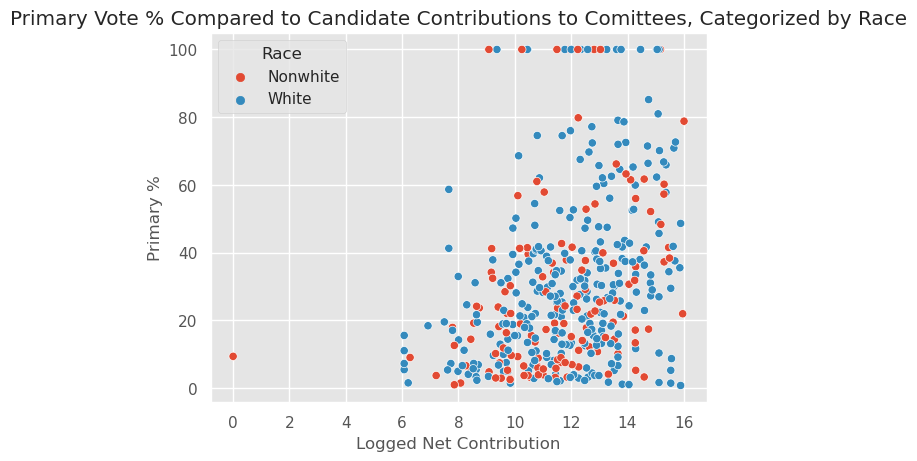

In [113]:
sns.scatterplot(data = cand_noout, x = "Logged Net Contribution", y = "Primary %", hue = "Race").set_title("Primary Vote % Compared to Candidate Contributions to Comittees, Categorized by Race");

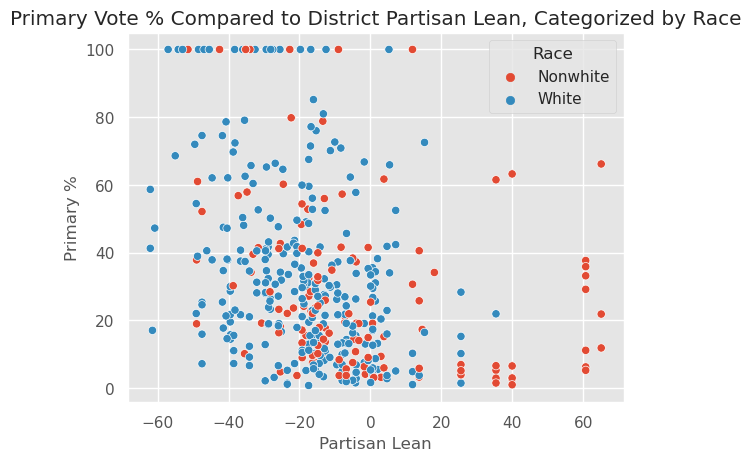

In [114]:
sns.scatterplot(data = cand_noout, x = "Partisan Lean", y = "Primary %", hue = "Race").set_title("Primary Vote % Compared to District Partisan Lean, Categorized by Race");

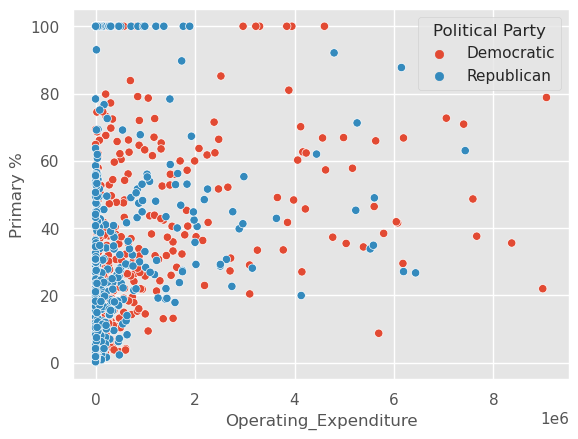

In [115]:
sns.scatterplot(data = cand_noout, x = "Operating_Expenditure", y = "Primary %", hue = "Political Party");#.set_title("Primary Vote % Compared to District Partisan Lean, Categorized by Race");

#### Research Question 1 Qualitative EDA

In [116]:
candidates["log Net Operating Expenditure"] = candidates["Net_Operating_Expenditure"].apply(np.log)
candidates["log Net Operating Expenditure"] = candidates["Net_Operating_Expenditure"].apply(np.log)

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1257: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1264: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1272: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


<Axes: title={'center': 'log Net Operating Expenditure'}, xlabel='Primary Status'>

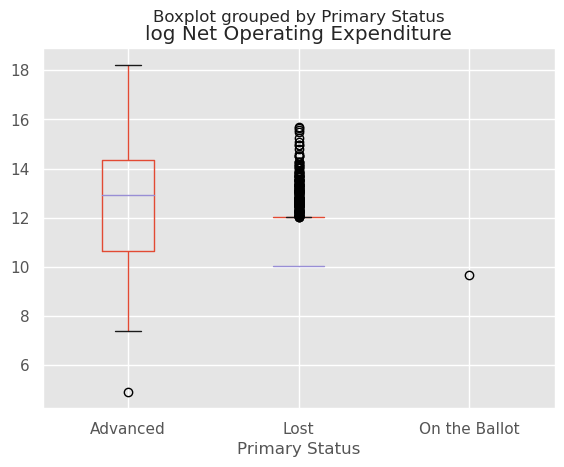

In [117]:
candidates.boxplot(column = "log Net Operating Expenditure", by = "Primary Status")

Box plot of Log Net Operating Expenditure broken down by Primary Status (Advanced and Lost). We see that those who advanced had a wider range of expenditure, and was generally higher than those who lost. It seems that those who lost stayed in a similar range (but with many exceptions). We will investigate these effects further by looking into different states and break it down by party. 

<Axes: title={'center': 'log Net Operating Expenditure'}, xlabel='Cand_Party_Affiliation'>

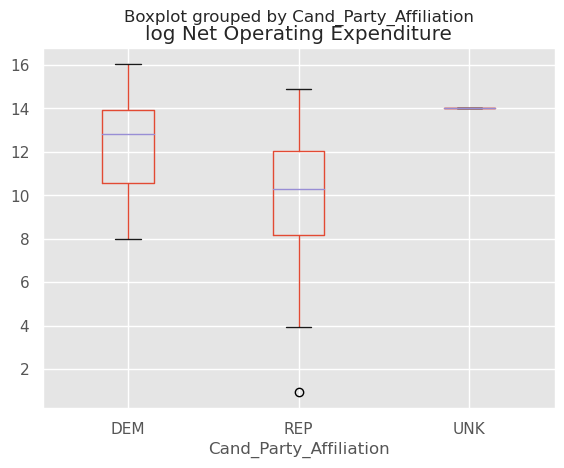

In [118]:
candidates[candidates["State"] == "CA"].boxplot(column = "log Net Operating Expenditure", by = "Cand_Party_Affiliation")

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


<Axes: title={'center': 'log Net Operating Expenditure'}, xlabel='Cand_Party_Affiliation'>

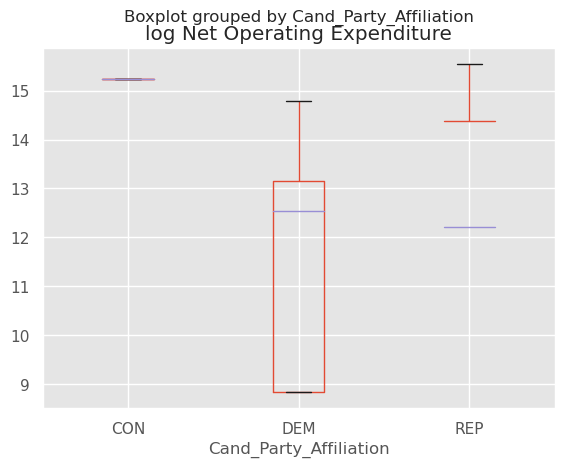

In [119]:
candidates[candidates["State"] == "WV"].boxplot(column = "log Net Operating Expenditure", by = "Cand_Party_Affiliation")

Looking in California, we see that Democrats spent more than Republicans. In West Virginia on the other hand, Democrats spent less than Republicans. This gives an indication that in our model, we should potentially add Party Affiliation as well as State into our model.

### Research Question 1 GLM

**Data Cleaning for GLM**

In [120]:
# Checking biggest contributors to NaN values
for column in cand_noout.loc[:, ["Won Primary", "Primary %", "Logged Net Contribution", "Logged Total Loan", "# Cands in Race"]]:
    print(column, "NaN Count:", cand_noout[column].isna().sum())

Won Primary NaN Count: 18
Primary % NaN Count: 10
Logged Net Contribution NaN Count: 0
Logged Total Loan NaN Count: 620
# Cands in Race NaN Count: 0


In [121]:
# Dropping rows with NaN values for the model to work
print("# of rows before dropping NaN values:", cand_noout.shape[0])
cand_noout["Logged Total Loan"] = cand_noout["Logged Total Loan"].replace(np.nan, 0)
cand_to_model = cand_noout.dropna(subset = ["Won Primary", "Advanced", "Primary %", "Logged Net Contribution", "Logged Total Loan", "# Cands in Race"])
print("# of rows after dropping NaN values:", cand_to_model.shape[0])

# of rows before dropping NaN values: 1069
# of rows after dropping NaN values: 1041


#### Bayesian GLM (Linear Regression)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Primary %_alpha, Intercept, Logged Net Contribution, Logged Operating Expenditures, Logged Total Loan, # Cands in Race]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


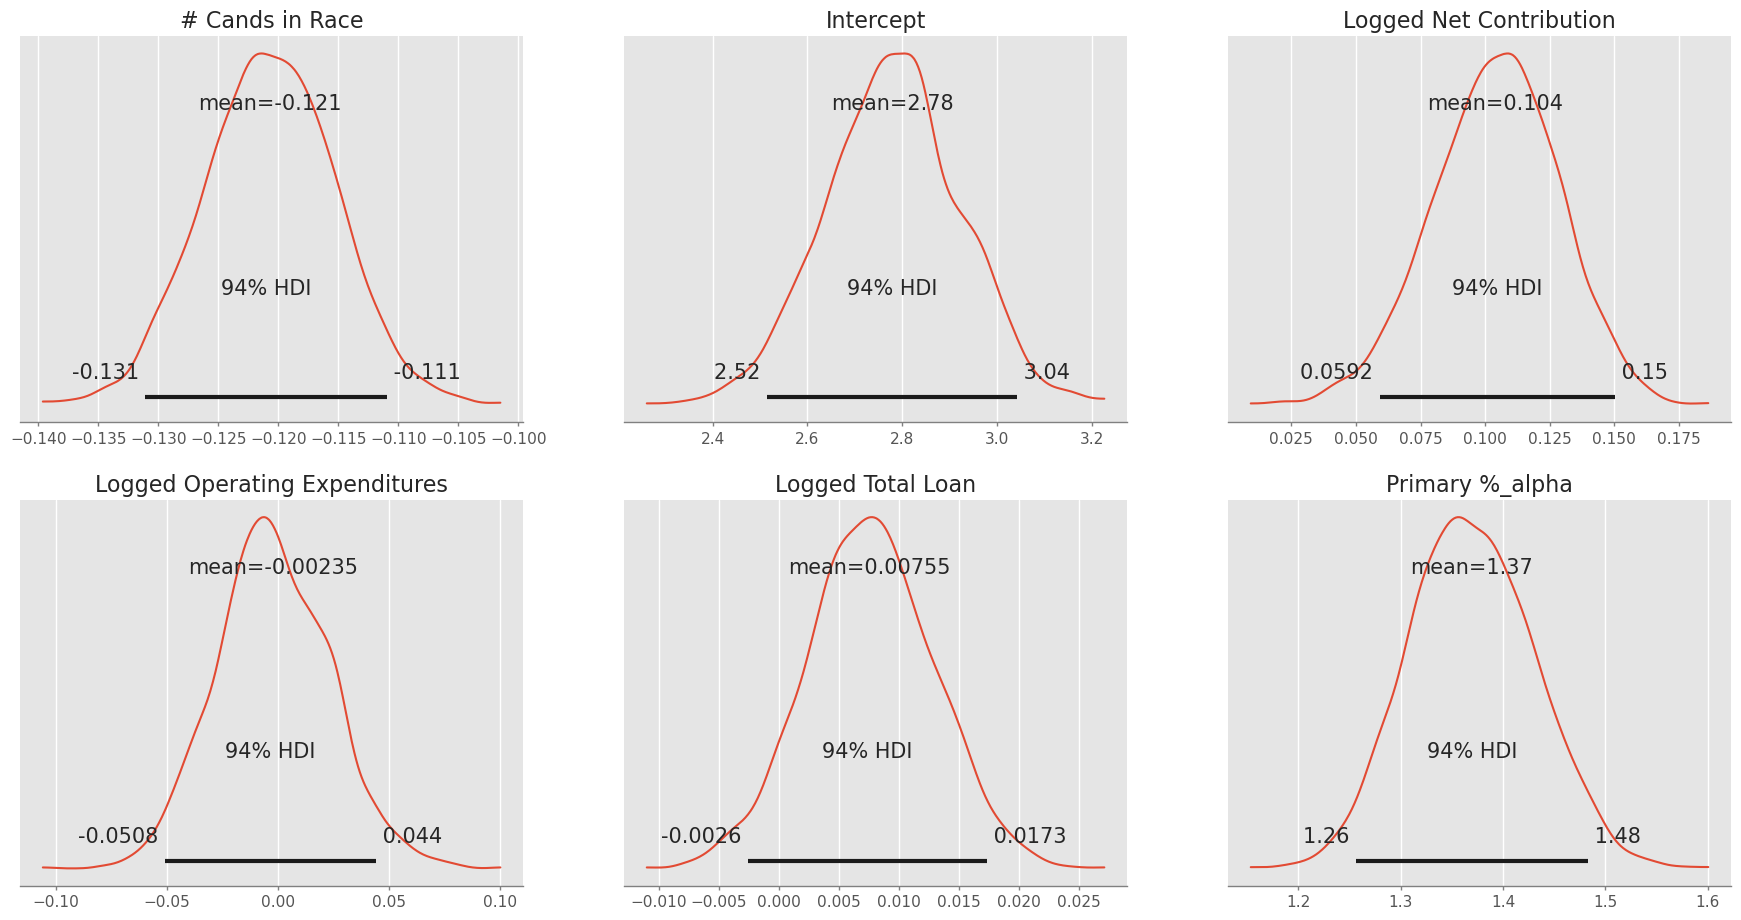

In [122]:
# Creating and fitting the model
cand_model = bmb.Model(formula = "'Primary %' ~ 'Logged Net Contribution' + 'Logged Operating Expenditures' + 'Logged Total Loan' + '# Cands in Race'", data = cand_to_model, family = "negativebinomial")
cand_model_samples = cand_model.fit(random_seed = 0)

# Plotting the posterior
az.plot_posterior(cand_model_samples, round_to = 3)
plt.show()

In [123]:
# Key summary and diagnostic info on the model parameters
az.summary(cand_model_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
# Cands in Race,-0.121,0.005,-0.131,-0.111,0.000,0.000,4200.0,3078.0,1.0
Intercept,2.779,0.142,2.516,3.043,0.002,0.002,4191.0,3113.0,1.0
Logged Net Contribution,0.104,0.024,0.059,0.150,0.000,0.000,2447.0,2434.0,1.0
Logged Operating Expenditures,-0.002,0.025,-0.051,0.044,0.001,0.000,2497.0,2549.0,1.0
Logged Total Loan,0.008,0.005,-0.003,0.017,0.000,0.000,4890.0,3150.0,1.0
Primary %_alpha,1.369,0.061,1.257,1.483,0.001,0.001,5626.0,3123.0,1.0


#### Bayesian GLM (Logistic Regression)

Modeling the probability that Advanced==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Logged Net Contribution, Logged Operating Expenditures, Logged Total Loan, # Cands in Race]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


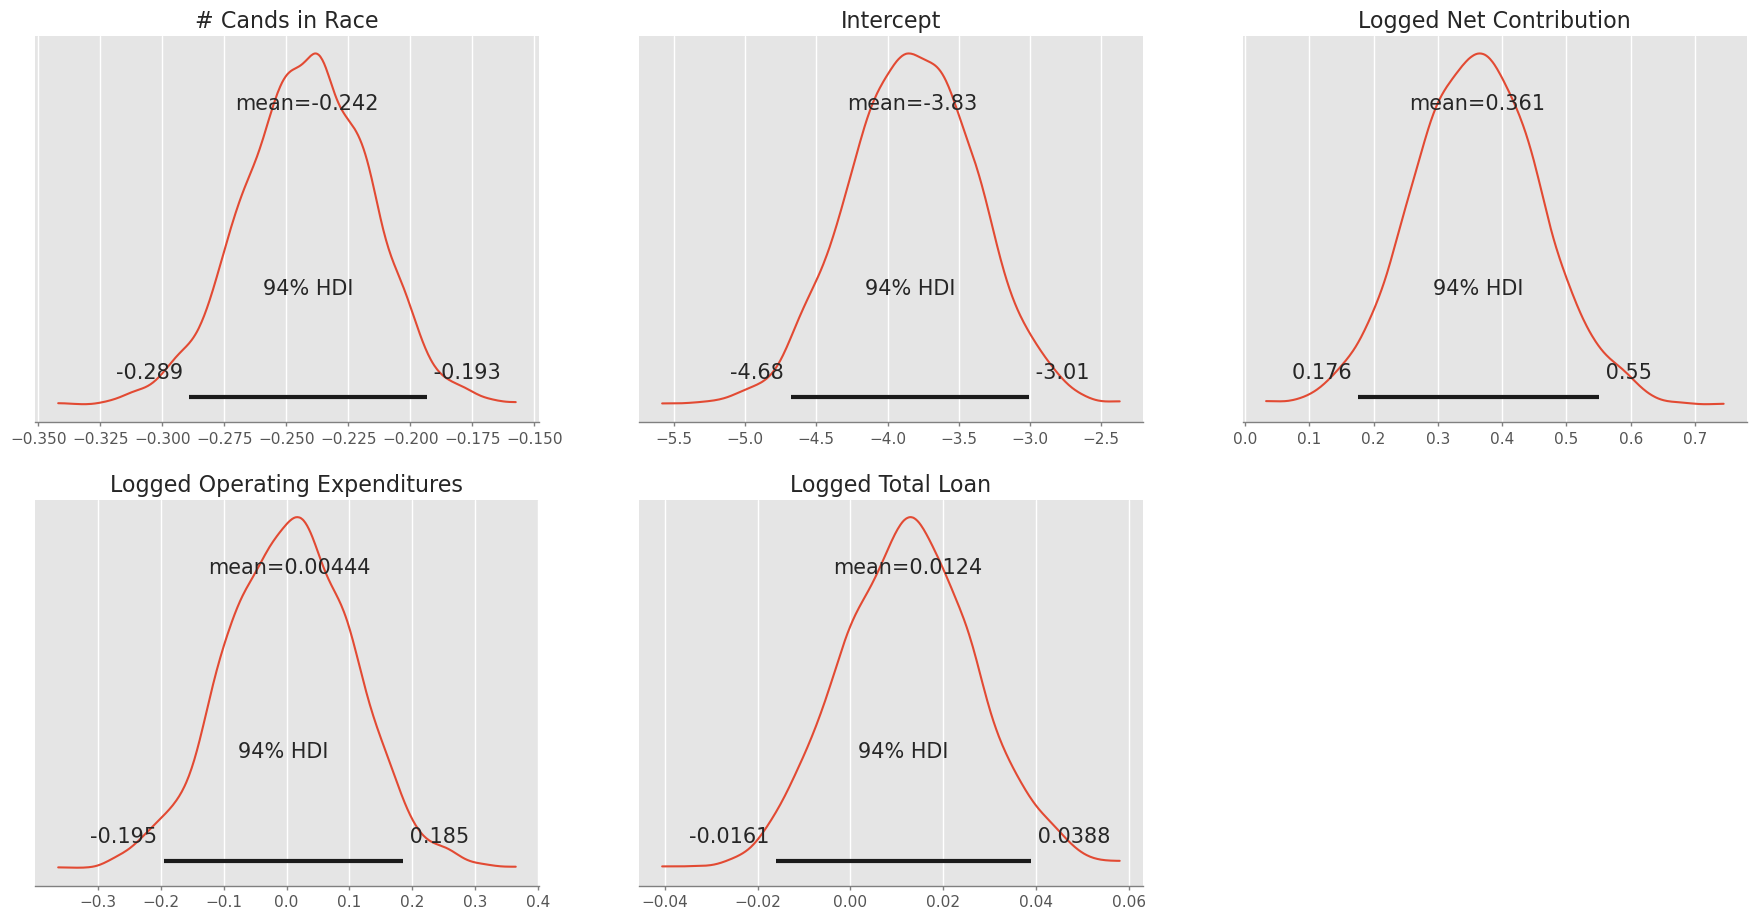

In [124]:
cand_model_logistic = bmb.Model(formula = "'Advanced' ~ 'Logged Net Contribution' + 'Logged Operating Expenditures' + 'Logged Total Loan' + '# Cands in Race'", data = cand_to_model, family = "bernoulli")
cand_model_samples_logistic = cand_model_logistic.fit(random_seed = 0)

# Plotting the posterior
az.plot_posterior(cand_model_samples_logistic, round_to = 3)
plt.show()

#### Frequentist GLM (Logistic Regression)

In [125]:
# Fit Poisson GLM model where Temp_Anomaly is a covariate (exogenous variable): No need to modify
freq_model = sm.Logit(cand_noout["Advanced"], exog = sm.add_constant(cand_noout[[
    'Logged Net Contribution','Logged Operating Expenditures','Logged Total Loan','# Cands in Race'
]]),
                  )
freq_res = freq_model.fit()
print(freq_res.summary())

Optimization terminated successfully.
         Current function value: 0.532719
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Advanced   No. Observations:                 1069
Model:                          Logit   Df Residuals:                     1064
Method:                           MLE   Df Model:                            4
Date:                Tue, 07 May 2024   Pseudo R-squ.:                  0.1726
Time:                        01:04:25   Log-Likelihood:                -569.48
converged:                       True   LL-Null:                       -688.24
Covariance Type:            nonrobust   LLR p-value:                 3.177e-50
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -3.7756      0.441     -8.564      0.

In [126]:
# Fit Poisson GLM model where Temp_Anomaly is a covariate (exogenous variable): No need to modify
freq_model_2 = sm.Logit(cand_noout["Advanced"], exog = sm.add_constant(cand_noout[[
    'Logged Net Contribution','# Cands in Race'
]]),
                  )
freq_res_2 = freq_model_2.fit()
print(freq_res_2.summary())

Optimization terminated successfully.
         Current function value: 0.533138
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Advanced   No. Observations:                 1069
Model:                          Logit   Df Residuals:                     1066
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 May 2024   Pseudo R-squ.:                  0.1719
Time:                        01:04:25   Log-Likelihood:                -569.93
converged:                       True   LL-Null:                       -688.24
Covariance Type:            nonrobust   LLR p-value:                 4.154e-52
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.7410      0.426     -8.783      0.000      -4.576   

In [127]:
print(freq_res.aic)
print(freq_res_2.aic)

1148.953362013216
1145.8500891986378


In [128]:
model_1_acc = np.mean((freq_res.predict() > .5) == (cand_noout["Advanced"] == 1))
model_2_acc = np.mean((freq_res_2.predict() > .5) == (cand_noout["Advanced"] == 1))
print("Model 1 Accuracy:", model_1_acc)
print("Model 2 Accuracy: ", model_2_acc)

Model 1 Accuracy: 0.7315247895229187
Model 2 Accuracy:  0.7268475210477081


### Research Question 1 Random Forest

In [129]:
train, test = train_test_split(cand_noout, test_size=0.25, random_state=101)

In [130]:
X_cols = ['Logged Net Contribution','Logged Operating Expenditures','Logged Total Loan','# Cands in Race']
y_col = "Advanced"

In [131]:
X = train.loc[:, X_cols]
y = train.loc[:, y_col]
forest_model.fit(X, y)
train["forest_pred"] = forest_model.predict(train.loc[:, X_cols])
test["forest_pred"] = forest_model.predict(test.loc[:, X_cols])

In [132]:
train_accuracy = np.mean((train["Advanced"] == 1) == train["forest_pred"])
test_accuracy = np.mean((test["Advanced"] == 1) == test["forest_pred"])
print("Training accuracy random forest:", train_accuracy)
print("Test accuracy random forest: ", test_accuracy)

Training accuracy random forest: 0.9762796504369539
Test accuracy random forest:  0.7425373134328358


## Research Question 2:
Does having a STEM background cause a candidate to win the primary?

In [133]:
dem_df = candidates[candidates['Political Party'] == 'Democratic']

#### Research Question 2 Quantitative EDA

Avg primary % difference: 2.4130007109397518


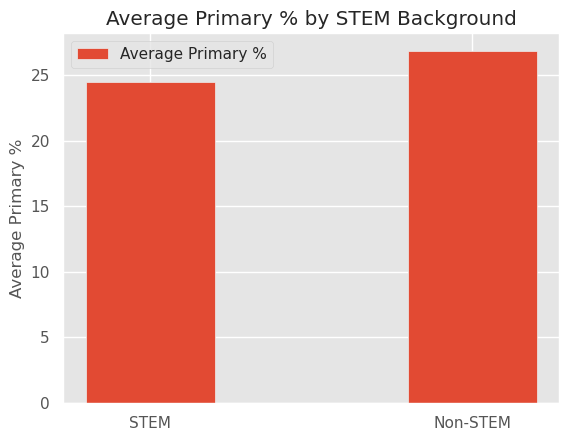

In [134]:
# Exclude unopposed candidates and candidates nominated by convention (not primary) (data points where primary % = 100)
stem_filter = (dem_df['STEM?'] == 'Yes') & (dem_df['Primary %'] != 100)
non_stem_filter = (dem_df['STEM?'] == 'No') & (dem_df['Primary %'] != 100)
avg_primary_percent = [(dem_df[stem_filter])['Primary %'].mean(), (dem_df[non_stem_filter])['Primary %'].mean()]
x = np.arange(2)
fig, ax = plt.subplots()
bars = ax.bar(x, avg_primary_percent, width = 0.4, label='Average Primary %')
ax.set_ylabel('Average Primary %')
ax.set_title('Average Primary % by STEM Background')
ax.set_xticks(x)
ax.set_xticklabels(['STEM', 'Non-STEM'])
ax.legend()
print('Avg primary % difference:', abs(avg_primary_percent[0] - avg_primary_percent[1]))

Avg Partisan Lean difference: 3.6701299843369313


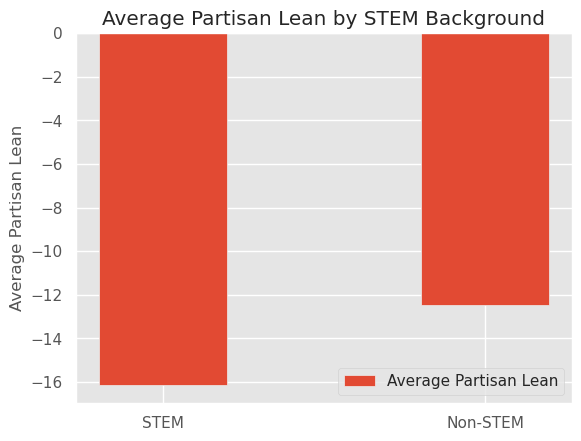

In [135]:
avg_partisan_lean = [((dem_df[stem_filter])['Partisan Lean']).mean(), ((dem_df[non_stem_filter])['Partisan Lean']).mean()]
x = np.arange(2)
fig, ax = plt.subplots()
bars = ax.bar(x, avg_partisan_lean, width = 0.4, label='Average Partisan Lean')
ax.set_ylabel('Average Partisan Lean')
ax.set_title('Average Partisan Lean by STEM Background')
ax.set_xticks(x)
ax.set_xticklabels(['STEM', 'Non-STEM'])
ax.legend()
print('Avg Partisan Lean difference:', abs(avg_partisan_lean[0] - avg_partisan_lean[1]))

In [136]:
stem_num = (dem_df[stem_filter])['Primary %'].shape[0]
print('# of STEM Democratic candidates:', stem_num)

# of STEM Democratic candidates: 109


In [137]:
non_stem_num = (dem_df[non_stem_filter])['Primary %'].shape[0]
print('# of Non-STEM Democratic candidates:', non_stem_num)

# of Non-STEM Democratic candidates: 411


In [138]:
print('% of STEM Democratic candidates:', round(stem_num / (stem_num + non_stem_num), 2))
print('% of Non-STEM Democratic candidates:', round(non_stem_num / (non_stem_num + stem_num), 2))

% of STEM Democratic candidates: 0.21
% of Non-STEM Democratic candidates: 0.79


Based on the two graphs above, we can see that the average primary % is almost 5% lower and the average partisan lean is almost 2 lower for having a STEM background. This suggests that on average, having a STEM background may put a candidate at a slight disadvantage when it comes to winning the election. However this is not a strong indication due to the disproportionate balance of data points between STEM and non-STEM. The % of STEM Democratic candidates is much lower, with only 18% of the data points being STEM and 82% being non-STEM (there are only 138 data points for STEM candidates compared to 619). Some possible reasons for the disproportionate balance of data points between STEM and non-STEM: people with a STEM background are less likely to be eligible to be a candidate for the primary election since there are way more non-STEM candidates than STEM candidates, people with a non-STEM background are more likely to sign up to be eligible to be a candidate than people with a STEM background (for whatever reason(s)). So having a STEM background might not be a strong factor in a candidate's likelihood of winning the primary election.

#### Research Question 2 Qualitative EDA

In [139]:
yes_stem = dem_df[dem_df['STEM?'] == 'Yes']
no_stem = dem_df[dem_df['STEM?'] == 'No']
ystem_prop_wins = len(yes_stem[yes_stem['Won Primary'] == 'Yes'])/len(yes_stem)
nstem_prop_wins = len(no_stem[no_stem['Won Primary'] == 'Yes'])/len(no_stem)
ystem_prop_wins, nstem_prop_wins

(0.25, 0.32494279176201374)

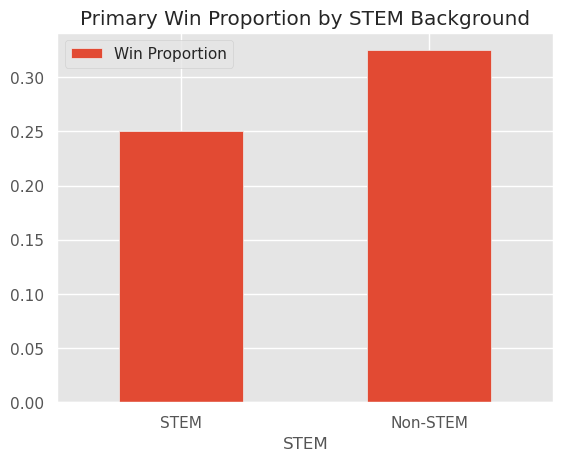

In [140]:
STEM_win_prop = pd.DataFrame({'STEM':['STEM', 'Non-STEM'], 'Win Proportion':[ystem_prop_wins, nstem_prop_wins]})
ax = STEM_win_prop.plot.bar(x='STEM', y='Win Proportion', rot=0)
plt.title('Primary Win Proportion by STEM Background')
plt.show()

In [141]:
ystem_self_funder = len(yes_stem[yes_stem['Self-Funder?'] == 'Yes'])/len(yes_stem)
nstem_self_funder = len(no_stem[no_stem['Self-Funder?'] == 'Yes'])/len(no_stem)
ystem_self_funder, nstem_self_funder

(0.07758620689655173, 0.032036613272311214)

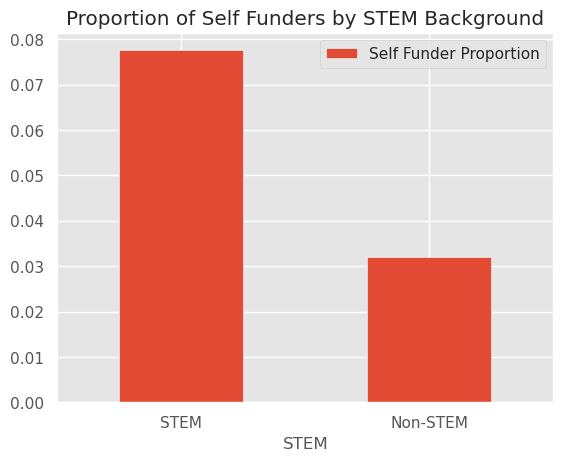

In [142]:
STEM_self_fund = pd.DataFrame({'STEM':['STEM', 'Non-STEM'], 'Self Funder Proportion':[ystem_self_funder, nstem_self_funder]})
ax2 = STEM_self_fund.plot.bar(x='STEM', y='Self Funder Proportion', rot=0)
plt.title('Proportion of Self Funders by STEM Background')
plt.show()

### Research Question 2 Results

In [143]:
relevant_vs = dem_df[['STEM?', 'Won Primary', 'Self-Funder?', 'Race', 'Partisan Lean', "Cand_Contribution", "Cand_Loan"]]
relevant_vs.replace(('Yes', 'No'), (1, 0), inplace=True)
relevant_vs.replace(('White', 'Nonwhite'), (1, 0), inplace=True)
filtered_dems = relevant_vs.dropna()

In [144]:
# Making Arrays
stem = filtered_dems['STEM?'].array
won = filtered_dems['Won Primary'].array
x = filtered_dems.iloc[:, 2:].to_numpy()

In [145]:
# import regression
from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=0)

In [146]:
# 3. Fit the model
ex_model = lr.fit(x, z)
ex_model.coef_

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[ 2.36166653e-05, -1.03720073e-03,  2.01271129e-02,
        -3.42872272e-06, -8.94950130e-08]])

In [147]:
def estimate_treatment_effect(LR, X, Y, Z):
    ex_model = LR.fit(X, Z)
    exs = ex_model.predict_proba(X)
    sum = 0
    for n in np.arange(len(X)):
        sum += (Z[n] * Y[n]/exs[n][1]) - ((1 - Z[n])*Y[n]/(1 - exs[n][1]))

    return sum/len(Z)

In [148]:
estimate_treatment_effect(lr, x, won, stem)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


-0.31048787787364374

According to the calculations we’ve made, having a STEM background has an average treatment effect of -0.31. Assuming that we were able to account for all potential confounders of having a STEM background and winning the primary, this should be a statistically significant estimate. Moreover, utilizing a propensity model, we can assume further accuracy of the different effects of each confounder. In terms of magnitude, -0.31 is a fairly large effect. This can be interpreted as having a 31% smaller chance of winning for candidates having a STEM background. For candidates, this can easily be the difference between winning and losing.